In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import shuffle


Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC2_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')


# @param Definition des table et colonnes --> Dépendent de la DB
DB             = "Archive2018_2019_prod"
TABLE_CONSO    = "Consommateur"
TABLE_ENTETE   = "Recette_entete_ticket"
TEMPS_ENTETE   = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE  = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL   = "Recette_detail_ticket"
TEMPS_DETAIL   = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL  = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE  = "Article_meti_HIST"
TABLE_UNIVERS  = "Univers"

Univers_Depth  = 3            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_client     = -1           # Nombre de clients à sélectionner. MAX = 148188. -1 --> ALL
client_tresh   = 15           # Nombre d'article que le client doit avoir acheter pour être mis dans un segment
univers_tresh  = 15           # Nombre d'article acheté de l'univers pour qu'il soit pris en compte

# @param Sur la normalization des données
Standard_Norm  = False        # Défini si on utilise la Normalization Standard
Standard_Tresh = 1            # Seuil d'acceptabilité des cluster en normalization standard
MinMax_Norm    = True         # Défini si on utilise la Normalization Minmax
MinMax_Tesh    = .3           # Seuil d'acceptabilité des cluster par défaut

# @param Sur le modèle KMean
K              = 14           # Nombre de segment. K = 21 -> 10% client d'exclu ; K = 15 -> 15% client exclu ; K = 9 -> 20% exclu 
n_init         = 50           # Nombre de run du KMean pour trouver le meilleur min

# @param Sur l'analyse des données
do_Analysis    = False        # Est-ce qu'on fait l'analyse des Elbow ou pas ?
Kmin           = 5            # Nombre de cluster au début de l'analyse
Kmax           = 30           # Nombre de cluster à la fin de l'analyse


# @param Hierchaical/Agglomerative Clustering
max_fitted = 10000
method     = 'ward'            # types de méthode: ward complete average single
 
# @param PCA
threeD         = False         # Afficher le graphe 3D dans les projection PCA
nbr_dim_keep   = 20            # Nombre de dimension gardée lors du KMeans effectué après un PCA    
K_PCA          = K             # K pour KMeans après le PCA

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_CONSO+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_CONSO+"]", conn)
print(df)

conn.close()

   Consommateur.KEY
0                -1
1                 1
2                 2
3                 3
4                 4
5                 5
6                 6
7                 7
8                 8
9                 9


## LOAD & PREPROCESSING DATA

In [4]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM  ['''      + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
ON ['''    + TABLE_DETAIL  + '''.''' + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''] 
ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
WHERE [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS  + '''.KEY] != -1 
AND ['''   + TABLE_ENTETE  + '''.Nombre_articles] > 0 
AND ['''   + TABLE_ENTETE  + '''.KEY] < ''' + str(5000000) + ''' 
AND ['''   + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388'''

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 5min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

client_tresh = 5
K = 14

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.KEY] AS Consommateur
FROM  [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
ON [Recette_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON    [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND   [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
WHERE [Article_meti_HIST.Univers.KEY] != -1 
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND [Recette_entete_ticket.KEY] < 5000000 
AND [Article_meti_HIST.Univers.KEY] != 388
Time Taken to load DB: ~188secondes
14312004


In [5]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.''' + TABLE_CONSO + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM  ['''      + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''] 
ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
ON ['''    + TABLE_DETAIL  + '''.'''    + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
WHERE [''' + TABLE_ENTETE  + '''.'''    + TABLE_CONSO   + '''.KEY] > 0 
AND   [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388'''
if nbr_client != -1:
    sql_command +=  ''' AND [''' + TABLE_ENTETE  +'''.'''     + TABLE_CONSO   + '''.KEY] < '''  + str(nbr_client)

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 3min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.Consommateur.KEY] AS Consommateur
FROM  [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON    [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND   [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
ON [Recette_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
WHERE [Recette_entete_ticket.Consommateur.KEY] > 0 
AND   [Article_meti_HIST.Univers.KEY] != 388
Time Taken to load DB: ~189secondes
10715545


In [6]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_my_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 0s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_my_univers)

SELECT [Univers.KEY],
    [Univers.Libelle_univers1_FR], 
    [Univers.Libelle_univers2_FR], 
    [Univers.Libelle_univers3_FR], 
    [Univers.Libelle_univers4_FR]
    FROM [Archive2018_2019_prod].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univers.KEY Univers.Libelle_univers1_FR Univers.Libelle_univers2_FR  \
0             -1                           ?                           ?   
1              1               PRET A MANGER      SERVICE TRAITEUR FROID   
2              2               PRET A MANGER                MEUBLE CHAUD   
3              3               PRET A MANGER                MEUBLE CHAUD   
4              4               PRET A MANGER                MEUBLE CHAUD   
..           ...                         ...                         ...   
485          485               PRET A MANGER                     SALADES   
486          486               PRET A MANGER                     SALADES   
487          487  APERITIF   ENTREES   TAPAS                     

In [7]:
univers_correspondance = {}
deleted = set()
for item in df_my_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_my_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{428: 1, 429: 1, 3: 2, 4: 2, 5: 2, 8: 7, 28: 27, 32: 31, 39: 38, 40: 38, 42: 41, 43: 41, 44: 41, 46: 45, 47: 45, 48: 45, 49: 45, 50: 45, 462: 51, 475: 51, 62: 61, 63: 61, 71: 70, 72: 70, 73: 70, 89: 88, 90: 88, 91: 88, 93: 92, 456: 125, 463: 125, 464: 125, 465: 125, 466: 125, 467: 125, 468: 125, 130: 129, 137: 136, 139: 138, 140: 138, 181: 180, 182: 180, 183: 180, 184: 180, 185: 180, 186: 180, 187: 180, 469: 213, 476: 213, 216: 215, 218: 217, 225: 224, 227: 226, 457: 228, 458: 228, 459: 228, 470: 228, 477: 228, 471: 229, 472: 229, 245: 244, 246: 244, 247: 244, 248: 244, 249: 244, 250: 244, 251: 244, 252: 244, 253: 244, 254: 244, 255: 244, 256: 244, 281: 280, 282: 280, 283: 280, 454: 322, 473: 322, 461: 325, 474: 325, 487: 327, 488: 327, 345: 344, 347: 346, 349: 348, 350: 348, 351: 348, 352: 348, 353: 348, 354: 348, 356: 355, 357: 355, 358: 355, 359: 355, 360: 355, 361: 355, 363: 362, 364: 362, 390: 362, 391: 362, 393: 392, 394: 392, 395: 392, 396: 392, 397: 392, 398: 392, 399: 392, 400

In [8]:
start = time()
dict_client_univ = {}

for i in range(nbr_data):
    univ   = df_univers[TABLE_UNIVERS][i]
    client = df_univers[TABLE_CONSO][i]
    if univ == -1:
        continue
    
    if univ in deleted:
        univ = univers_correspondance[univ]
    
    if not client in dict_client_univ:
        dict_client_univ[client] = {}
        
    if not univ in dict_client_univ[client]:
        dict_client_univ[client][univ] = 0
    dict_client_univ[client][univ] += 1

to_remove = []
for k,v in dict_client_univ.items():
    if sum(v.values()) < client_tresh:
        to_remove.append(k)
    elif not Standard_Norm:
        maxi = max(v.values())
        dict_client_univ[k] = {key:value/maxi for key,value in v.items()}

for k in to_remove:
    del dict_client_univ[k]
        
    
clients_data = pd.DataFrame(index = dict_client_univ.keys(),
                        data = dict_client_univ.values())
clients_data = clients_data.replace(float('NaN'), 0)
 
print(clients_data)

# environ 10s * nbr_client/10.000
print("Time Taken to load Dataframe: ~" + str(int(time() - start)) + "secondes")

             196       344       294       299       392       117       402  \
58834   0.058824  0.029412  0.176471  1.000000  0.382353  0.088235  0.088235   
92009   0.000000  0.000000  0.000000  0.104839  1.000000  0.000000  0.016129   
71702   0.016667  0.000000  0.050000  0.083333  0.075000  0.083333  0.100000   
76286   0.000000  0.000000  0.272727  0.696970  0.030303  0.000000  0.000000   
67075   0.000000  0.000000  0.045276  1.000000  0.690945  0.001969  0.043307   
...          ...       ...       ...       ...       ...       ...       ...   
147936  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.500000   
147915  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
147951  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
147923  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   
147930  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

             51        258       114  .

In [9]:
# Standard Normalization
def standard_normalization(df):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df)
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

# Min-Max Normalization
def minmax_normalization(df):
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(df) 
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

norm_clients_data = clients_data.copy()

if Standard_Norm:
    norm_clients_data = standard_normalization(norm_clients_data)
if MinMax_Norm:
    norm_clients_data = minmax_normalization(norm_clients_data)
    
if MinMax_Norm or not Standard_Norm: 
    for column in norm_clients_data:
        if sum(norm_clients_data[column]) < univers_tresh:
            norm_clients_data = norm_clients_data.drop(columns = column)

# shuffle rows        
norm_clients_data = shuffle(norm_clients_data) 
# shuffle columns
norm_clients_data = norm_clients_data[shuffle(norm_clients_data.columns)]
print(norm_clients_data)

        433  76   336       150   174  271  191  270  277       148  ...  190  \
61317   0.0  0.0  0.0  0.000000  0.00  0.0  0.0  0.0  0.0  0.000000  ...  0.0   
16087   0.0  0.0  0.0  0.000000  0.00  0.0  0.0  0.0  0.0  0.285714  ...  0.0   
128178  0.0  0.0  0.0  0.000000  0.00  0.0  0.0  0.0  0.0  0.000000  ...  0.0   
22534   0.0  0.0  0.0  0.057143  0.00  0.0  0.0  0.0  0.0  0.428571  ...  0.0   
69253   0.0  0.0  0.0  0.000000  0.25  0.0  0.0  0.0  0.0  0.000000  ...  0.0   
...     ...  ...  ...       ...   ...  ...  ...  ...  ...       ...  ...  ...   
121667  0.0  0.0  0.0  0.000000  0.00  0.0  0.0  0.0  0.0  0.166667  ...  0.0   
128229  0.0  0.0  0.0  0.000000  0.00  0.0  0.0  0.0  0.0  0.000000  ...  0.0   
125362  0.0  0.0  0.0  0.000000  0.00  0.0  0.0  0.0  0.0  0.000000  ...  0.0   
22685   0.0  0.0  0.0  0.000000  0.00  0.0  0.0  0.0  0.0  0.142857  ...  0.0   
13161   0.0  0.0  0.0  0.000000  0.00  0.0  0.0  0.0  0.0  0.000000  ...  0.0   

        18   338  306  81  

# SEGMENTATION DE LA CLIENTELE PAR KMEANS

In [10]:
def Elbow(dataframe, Kmin, Kmax):
    start = time()
    
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(dataframe)
        distorsions.append(model.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [11]:
def Eclude_Elbow(dataframe, Kmin, Kmax, treshold, method = 'ward', Algo= 'KMeans'):
    start = time()

    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        if Algo == 'KMeans':
            model = KMeans(n_clusters=k)
        elif Algo == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=method)
        
        model.fit(dataframe)
        cluster = model.predict(dataframe)
        cluster_centers = model.cluster_centers_

        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([(1 if c > treshold else 0) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve.jpg")
    
    plt.show()
    

    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [12]:
def Dendogram(dataframe, mehtod = 'ward'):
    start  = time()
    method = mehtod            # types de méthode: ward complete average single
    
    plt.figure(figsize=(15, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(dataframe, method=method),
                          p = 50,
                          truncate_mode = 'level')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Dendogram_"+method+".jpg")
    plt.show()


    # Enivron 250s*(client/10000)²
    print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [13]:
def Analysis(dataframe, treshold, Kmin=5, Kmax=30, method = 'ward', Algo= 'KMeans'):
    if Algo == 'KMeans':
        Elbow(dataframe, Kmin, Kmax)   
        Eclude_Elbow(dataframe, Kmin, Kmax, treshold, method, Algo)
    elif Algo == 'hierarchical':
        Dendogram(dataframe, mehtod = method)
    else:
        print("Wrong Algo as input : choose beetween 'KMeans' or 'hierarchical'")
        return

In [14]:
def get_interest(cluster_center, treshold, columns):
    interest = {i:[] for i in range(K)}

    for i in range(len(cluster_center)):
        for key,val in cluster_center[i].items():
            if val > treshold:
                interest[i].append(key)
    
#     for i in range(len(cluster_centers)):
#         for j in range(len(cluster_centers[i])):
#             if cluster_centers[i][j] > treshold:
#                 interest[i].append(columns[j])
                
    return interest

In [15]:
def print_interest(conn, interest, cluster, cluster_centers, columns):
    NACK = 0

    conn = engine.connect()
    for key,values in interest.items():
        print("\n\nCluster", key, end=': ')
        proportion = cluster.tolist().count(key)*100/len(cluster)
        print(round(proportion,2),"%",)

        if len(values) == 0:
            NACK += proportion
            continue

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in values:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]
        #print(sql_command)

        df_libele = pd.read_sql(sql_command, conn)

#         df_libele["Power"] = [round(cluster_centers[key][list(columns).index(i)],2) for i in values]
        df_libele["Power"] = [round(cluster_centers[key][i],2) for i in values]

        print(df_libele.sort_values("Power", ascending=False).to_string(index=False))
    conn.close()

    print("\nNACK =", round(NACK,2),"%")

In [16]:
if do_Analysis:
    Analysis(norm_clients_data, treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax)

In [17]:
start = time()
model = KMeans(K, n_init = n_init)
model.fit(norm_clients_data)
cluster = model.labels_
# environ 1s * n_init * K/10
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~78secondes


In [18]:
cluster_centers = model.cluster_centers_
cluster_centers = [{norm_clients_data.columns[j]:cluster_centers[i][j] 
                    for j in range(len(cluster_centers[i]))} 
                   for i in range(len(cluster_centers))]
interest = get_interest(cluster_centers, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh,
                       norm_clients_data.columns)

print_interest(conn, interest, cluster, cluster_centers, norm_clients_data.columns)



Cluster 0: 4.39 %
 Univ_KEY                     Univ_1                       Univ_2            Univ_3  Power
      322 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS             CHIPS   0.72
      392              PRET A MANGER                   SANDWICHES SANDWICHES FROIDS   0.48
      405              PRET A MANGER               PLATS PREPARES      ITALIAN FOOD   0.47
      299             PETIT DEJEUNER                 VIENNOISERIE     VIENNOISERIES   0.42
      297             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS             PAINS   0.37
      403              PRET A MANGER               PLATS PREPARES    TRADITION FOOD   0.34
      228                   BOISSONS                  SOFT DRINKS              SODA   0.32


Cluster 1: 12.22 %
 Univ_KEY        Univ_1     Univ_2            Univ_3  Power
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS   0.97


Cluster 2: 14.22 %


Cluster 3: 11.96 %
 Univ_KEY         Univ_1       Univ_2        Univ_3  Power
      299 

In [19]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~585secondes


# VISUALISATION PCA

In [20]:
def PCA_Visualisation(data, target=[], centroid=[], method = "", threeD = False):
    start = time()

    model_pca = PCA(n_components= 2)
    predict = model_pca.fit(data).transform(data)
    
    
    print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))
    
    plt.figure(figsize=(15, 7))  
    if list(target):
        plt.scatter(predict[:,0],predict[:,1], c=target, alpha=.8)
    else: 
        plt.scatter(predict[:,0],predict[:,1])
    if list(centroid):
        clust_predict = model_pca.transform(centroid)
        plt.scatter(clust_predict[:,0],clust_predict[:,1], color='r')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of dataset - ' + method + ' - Cluster = ' + str(K))

    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster-"+str(K)+"-"+method+".jpg")
    
    if threeD:
        model_pca = PCA(n_components= 3)
        predict = model_pca.fit(data).transform(data)
        print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))


        plt.figure(figsize=(30, 30)) 
        ax = plt.axes(projection='3d')

        ax.scatter3D(predict[:,0], predict[:,1], predict[:,2], c=target);

        plt.title('PCA of dataset in 3D - ' + method)

        if save_fig:
            plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster_3D-"+str(K)+"-"+method+".jpg")
    
    # environ 1.5s
    print("Time Taken to show PCA : ~" + str(int(time() - start)) + "secondes")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.0694071  0.05792983]
Time Taken to show PCA : ~0secondes


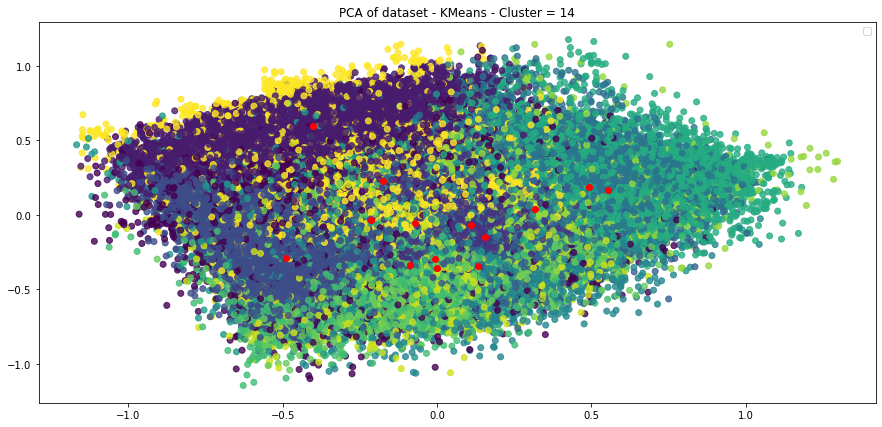

In [21]:
PCA_Visualisation(norm_clients_data,
                  cluster, 
                  [list(dic.values()) for dic in cluster_centers],
                  method = 'KMeans',
                  threeD = threeD)

# SEGMENTATION HIERARCHICAL CLUSTERING

In [22]:
if do_Analysis:
    Analysis(norm_clients_data.head(max_fitted),
             treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = 5, Kmax = 10, 
             method = 'ward', Algo= 'hierarchical')

In [23]:
start = time()

hierarchical_model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=method)  
hierarchical_model.fit(norm_clients_data.head(max_fitted))
print(hierarchical_model)
# 15s * (N/10k)²
print("Time Taken to fit/predict model : ~" + str(int(time() - start)) + "secondes")

AgglomerativeClustering(n_clusters=14)
Time Taken to fit/predict model : ~15secondes


In [24]:
def get_centroid(dataframe, cluster, K):
    cluster_center   = [{c:0 for c in norm_clients_data.columns} for _ in range(K)]
    proportion = [0 for _ in range(K)]
    for i in range(len(cluster)):
        for c in dataframe.columns:
            cluster_center[cluster[i]][c] += dataframe[c][dataframe.index[i]]
        proportion[cluster[i]]  += 1
        
    for i in range(K):
        for c in dataframe.columns:
            cluster_center[i][c] /= proportion[i]
            
    return cluster_center

In [25]:
start = time()

hierarchical_cluster  = hierarchical_model.labels_
hierarchical_centroid = get_centroid(norm_clients_data, hierarchical_cluster, K)

In [26]:
hierarchical_interest = get_interest(hierarchical_centroid, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh,
                       norm_clients_data.columns)

print_interest(conn, hierarchical_interest, hierarchical_cluster, list(hierarchical_centroid), norm_clients_data.columns)

# environ 30s
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")



Cluster 0: 5.5 %
 Univ_KEY         Univ_1                       Univ_2    Univ_3  Power
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     PAINS   0.58
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS BAGUETTES   0.52


Cluster 1: 12.37 %
 Univ_KEY         Univ_1       Univ_2        Univ_3  Power
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES   0.89


Cluster 2: 8.94 %
 Univ_KEY        Univ_1         Univ_2         Univ_3  Power
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD    0.9
      405 PRET A MANGER PLATS PREPARES   ITALIAN FOOD    0.4


Cluster 3: 22.32 %


Cluster 4: 3.73 %
 Univ_KEY          Univ_1             Univ_2                Univ_3  Power
      299  PETIT DEJEUNER       VIENNOISERIE         VIENNOISERIES   0.67
      231        BOISSONS        SOFT DRINKS BOISSONS ENERGISANTES   0.35
      272 TABACS   PRESSE TABAC   CIGARETTES    TABAC   CIGARETTES   0.34


Cluster 5: 6.65 %
 Univ_KEY           Univ_1  Univ_2         Univ_3  Power
      180 FR

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07008239 0.05755806]
Time Taken to show PCA : ~0secondes


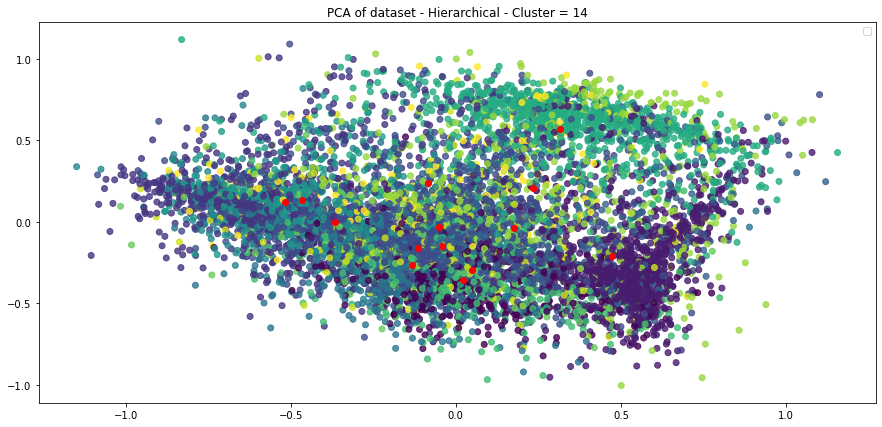

In [27]:
PCA_Visualisation(norm_clients_data.head(max_fitted), 
                  hierarchical_cluster,
                  [list(dic.values()) for dic in hierarchical_centroid],
                  method = 'Hierarchical',
                  threeD = threeD)

In [28]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~630secondes


## PCA Dimension reductor + KMeans

In [29]:
def PCA_Analysis(dataframe):
    min_analyzed_dim = 0
    max_analyzed_dim = len(dataframe.columns)
    
    model_pca = PCA(n_components= max_analyzed_dim)
    predict = model_pca.fit(dataframe).transform(dataframe)
    
    total_coef = {i:1-sum(model_pca.explained_variance_ratio_[:i]) 
                  for i in range(min_analyzed_dim,max_analyzed_dim)}
    print(total_coef)
    plt.figure(figsize=(15, 7)) 
    plt.plot(total_coef.keys(), total_coef.values())
    plt.grid(True)
    plt.title('PCA Reduction : Quantitée Relative Perdue en fonction du nombre de dimension')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Reduction_Proportion.jpg")
    
    plt.show()
if do_Analysis:
    PCA_Analysis(norm_clients_data)

In [30]:
model_pca = PCA(n_components= nbr_dim_keep)
predict = model_pca.fit(norm_clients_data).transform(norm_clients_data)

In [31]:
new_datas = pd.DataFrame(index=norm_clients_data.index, data = predict)
print(new_datas)

              0         1         2         3         4         5         6   \
61317  -0.288759  0.629473  0.725108  0.286048 -0.179005  0.538947 -0.317865   
16087   0.005070 -0.261731 -0.346180 -0.052217  0.158904 -0.078917 -0.599342   
128178 -0.482605 -0.430797  0.197137 -0.543277 -0.199212  0.009580  0.063837   
22534   0.453151  0.260339  0.602653  0.883908 -0.326536 -0.168290  0.184080   
69253  -0.344692  0.760983 -0.335022  0.041043  0.067492 -0.071504 -0.049216   
...          ...       ...       ...       ...       ...       ...       ...   
121667  0.017497 -0.142766 -0.266096  0.280987  0.080150  0.101373 -0.418164   
128229  0.314197  0.031366  0.322565 -0.352971 -0.212019 -0.653085 -0.005332   
125362 -0.187501  0.879934  0.067807  0.031348  0.062413  0.133413 -0.061617   
22685   0.306114 -0.147485 -0.116699 -0.080479  0.115362 -0.364850 -0.253394   
13161  -0.493586 -0.443410  0.170899 -0.439159 -0.269734  0.069650  0.116155   

              7         8         9    

In [32]:
if do_Analysis:
    Analysis(new_datas, treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax)

In [33]:
start = time()

model = KMeans(K_PCA, n_init = n_init)
model.fit(new_datas)

# environ 10s
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~31secondes


In [34]:
start = time()

PCA_cluster  = model.labels_
PCA_centroid = get_centroid(norm_clients_data, PCA_cluster, K_PCA)        
        
PCA_interest = get_interest(PCA_centroid, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh,
                       norm_clients_data.columns)

print_interest(conn, PCA_interest, PCA_cluster, PCA_centroid, norm_clients_data.columns)

#environ 2min
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes



Cluster 0: 5.05 %
 Univ_KEY         Univ_1                       Univ_2 Univ_3  Power
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS   0.95


Cluster 1: 12.52 %
 Univ_KEY         Univ_1       Univ_2        Univ_3  Power
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES   0.97


Cluster 2: 4.35 %
 Univ_KEY          Univ_1             Univ_2             Univ_3  Power
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES   0.92


Cluster 3: 4.92 %
 Univ_KEY                     Univ_1                    Univ_2 Univ_3  Power
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS   0.91


Cluster 4: 9.39 %
 Univ_KEY        Univ_1         Univ_2         Univ_3  Power
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD   0.96
      405 PRET A MANGER PLATS PREPARES   ITALIAN FOOD   0.35


Cluster 5: 3.91 %
 Univ_KEY   Univ_1 Univ_2 Univ_3  Power
      244 BOISSONS   VINS FRANCE   0.93


Cluster 6: 7.0 %
 Univ_KEY        Univ_1      Univ_2            

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.0694071  0.05792984]
Time Taken to show PCA : ~0secondes


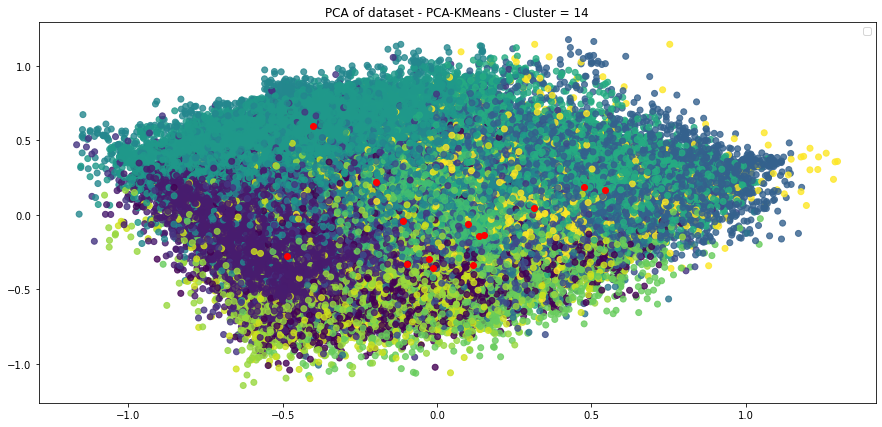

In [36]:
PCA_Visualisation(norm_clients_data, 
                  PCA_cluster, 
                  [list(dic.values()) for dic in PCA_centroid],
                  method = 'PCA-KMeans',
                  threeD = threeD)

In [37]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~10314secondes


## Reconstruction des résultats du KMeans A LA MAIN

In [ ]:
cluster_correspondance = {0:0, 1:1, 2:2, 3:3, 4:0, 5:1, 6:4,7:5, 8:6, 9:7, 10:0, 11:3, 12:0, 13:8}
new_cluster = []
for c in cluster:
    new_cluster.append(cluster_correspondance[c])
new_cluster_center = [[0 for _ in range(len(cluster_centers[0]))] for _ in range(9)]
cluster_proportion = [0 for _ in range(9)]
for i in range(len(cluster_centers)):
    cluster_proportion[cluster_correspondance[i]] += cluster.tolist().count(i)
    for j in range(len(cluster_centers[i])):
        new_cluster_center[cluster_correspondance[i]][j] += cluster_centers[i][j]*cluster.tolist().count(i)

for i in range(len(new_cluster_center)):
    for j in range(len(new_cluster_center[i])):
        new_cluster_center[i][j] /= cluster_proportion[i]

In [ ]:
PCA_Visualisation(norm_clients_data, 
                  new_cluster, 
                  new_cluster_center, 
                  method = 'KMeans rebuild to 9', 
                  threeD = threeD)

In [ ]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

In [ ]:
# conn = engine.connect()

# for i in range(len(cluster)):
#     sql_cmd = '''UPDATE  ['''+DB+'''].[DWH].[Dim_'''+TABLE_CONSO+''']
#     SET ['''+TABLE_CONSO+'''.Segment_Clientele] = ''' + str(cluster_correspondance[cluster[i]]) +''' 
#     WHERE ['''+TABLE_CONSO+'''.KEY] = ''' + str(norm_clients_data.index[i])
    
#     conn.execute(sql_cmd)
    
#     if not i % 1000:
#         print(i*100/len(cluster), "%")
# conn.close()

In [ ]:
print(norm_clients_data)
PCA_Visualisation(norm_clients_data, method = 'Standard Normalization')